In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '2,3'

In [2]:
val_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

valset = torchvision.datasets.ImageFolder(root='../data/val/', transform=val_transform)
valloader = torch.utils.data.DataLoader(valset, batch_size=5, shuffle=False, num_workers=4)

vis_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor()
])

visset = torchvision.datasets.ImageFolder(root='../data/val/', transform=vis_transform)
visloader = torch.utils.data.DataLoader(visset, batch_size=5, shuffle=False, num_workers=4)

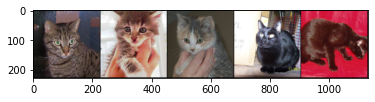

tensor([0, 0, 0, 0, 0])


In [3]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(visloader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))
print(labels)

In [4]:
from ResNet_hc import resnet101

model = resnet101(2)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = nn.DataParallel(model)
model.to(device)
model.load_state_dict(torch.load('checkpoint/ResNet101_Cats_Dogs_hc.pth'))

In [5]:
model.eval()
valdataiter = iter(valloader)
x,y = valdataiter.next()
x = x.to(device)
x.requires_grad_()
y = y.to(device)
saliency = None

logits = model.forward(x)
logits = logits.gather(1, y.view(-1, 1)).squeeze() # 得到正确分类
logits.backward(torch.cuda.FloatTensor([1., 1., 1., 1., 1.])) # 只计算正确分类部分的loss

saliency = abs(x.grad.data) # 返回X的梯度绝对值大小
saliency, _ = torch.max(saliency, dim=1)  # 一个pixel只取最大值
saliency.squeeze() 

tensor([[[0.0049, 0.0060, 0.0064,  ..., 0.0007, 0.0007, 0.0013],
         [0.0062, 0.0079, 0.0075,  ..., 0.0006, 0.0017, 0.0018],
         [0.0021, 0.0056, 0.0076,  ..., 0.0013, 0.0029, 0.0016],
         ...,
         [0.0053, 0.0057, 0.0223,  ..., 0.0048, 0.0043, 0.0036],
         [0.0111, 0.0134, 0.0083,  ..., 0.0063, 0.0105, 0.0086],
         [0.0069, 0.0144, 0.0027,  ..., 0.0110, 0.0103, 0.0021]],

        [[0.0150, 0.0100, 0.0160,  ..., 0.0040, 0.0022, 0.0071],
         [0.0134, 0.0095, 0.0110,  ..., 0.0038, 0.0019, 0.0090],
         [0.0088, 0.0137, 0.0046,  ..., 0.0077, 0.0031, 0.0068],
         ...,
         [0.0011, 0.0011, 0.0030,  ..., 0.0009, 0.0004, 0.0006],
         [0.0007, 0.0032, 0.0018,  ..., 0.0013, 0.0005, 0.0012],
         [0.0005, 0.0029, 0.0019,  ..., 0.0006, 0.0002, 0.0004]],

        [[0.0082, 0.0091, 0.0055,  ..., 0.0218, 0.0102, 0.0170],
         [0.0142, 0.0143, 0.0106,  ..., 0.0047, 0.0031, 0.0095],
         [0.0170, 0.0268, 0.0342,  ..., 0.0192, 0.0054, 0.

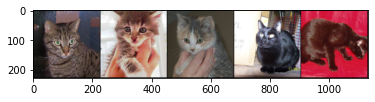

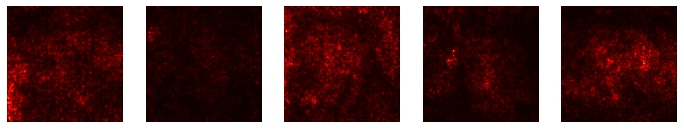

In [6]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(visloader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))

saliency = saliency.cpu().numpy()
for i in range(5):
    plt.subplot(2, 5, i + 1)
    plt.imshow(saliency[i], cmap=plt.cm.hot)
    plt.axis('off')
    plt.gcf().set_size_inches(12, 5)
plt.show()